#Author : Qingchen YANG & Yanan CHEN

In [3]:
%matplotlib inline

# Setup and load demonstration data

A few machine learning and reinforcement libraries have been developped. For instance, you can look at :

*    stable baselines: short documentation at https://stable-baselines.readthedocs.io/_/downloads/en/v2.4.0/pdf/ ; long documentation for the version 3 at https://stable-baselines3.readthedocs.io/en/master/guide/rl.html. There is also a page dedicated to imitation on https://stable-baselines3.readthedocs.io/en/master/guide/imitation.html
*    rlkit library developped by berkeley,. It proposes a reinforcement learning framework and algorithms implemented in PyTorch. The repository is on https://github.com/vitchyr/rlkit/



The imitation library implements imitation learning algorithms on top of Stable-Baselines3, including:

*        Behavioral Cloning

*       DAgger with synthetic examples

*        Adversarial Inverse Reinforcement Learning (AIRL)

*        Generative Adversarial Imitation Learning (GAIL)




It also provides CLI scripts for training and saving demonstrations from RL experts, and for training imitation learners on these demonstrations.


We will follow the code proposed in https://stable-baselines3.readthedocs.io/en/master/guide/imitation.html.

For more documentation on stable-baselines, see :
* https://stable-baselines3.readthedocs.io/en/master/guide/quickstart.html
* https://stable-baselines3.readthedocs.io/en/master/guide/algos.html shows a guide to the implemented algorithms
* https://github.com/DLR-RM/stable-baselines3 for the code of stable-baselines

In [4]:
!pip install stable_baselines --upgrade
!pip install imitation


     |████████████████████████████████| 240 kB 4.0 MB/s 
     |████████████████████████████████| 89 kB 3.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 128 kB 29.3 MB/s 
     |████████████████████████████████| 106 kB 40.2 MB/s 
     |████████████████████████████████| 3.8 MB 41.7 MB/s 
     |████████████████████████████████| 448 kB 63.5 MB/s 
     |████████████████████████████████| 65.1 MB 113 kB/s 
     |████████████████████████████████| 99 kB 7.1 MB/s 
     |████████████████████████████████| 181 kB 5.0 MB/s 
     |████████████████████████████████| 547 kB 37.0 MB/s 
     |████████████████████████████████| 8.7 MB 33.6 MB/s 
     |████████████████████████████████| 79 kB 6.6 MB/s 
     |████████████████████████████████| 127 kB 52.9 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  Created wheel for imitation: filename=imitation-0.2.0-py3-none-any.whl

In [5]:
# Libraries
# Colab libraries
from google.colab import drive
from google.colab import output
drive.mount('/content/gdrive')
colab_path = "/content/gdrive/MyDrive/"

Mounted at /content/gdrive


Download the file https://raw.githubusercontent.com/HumanCompatibleAI/imitation/master/tests/data/expert_models/cartpole_0/rollouts/final.pkl and put it in your google drive Colab Notebook folder.

In [4]:
import sys
%cd $colab_path
sys.path.append('.'); sys.argv=['']

/content/gdrive/MyDrive


In [5]:
"""Loads CartPole-v1 demonstrations and trains BC and GAIL models on that data.
"""

import pathlib
import pickle
import tempfile

import stable_baselines3 as sb3
from imitation.algorithms import adversarial, bc


from imitation.data import rollout
from imitation.util import logger, util

# Load pickled test demonstrations.
with open("expert_data_CartPole.pkl", "rb") as f:
    # This is a list of `imitation.data.types.Trajectory`, where
    # every instance contains observations and actions for a single expert
    # demonstration.
    trajectories = pickle.load(f)

# Convert List[types.Trajectory] to an instance of `imitation.data.types.Transitions`.
# This is a more general dataclass containing unordered
# (observation, actions, next_observation) transitions.
transitions = rollout.flatten_trajectories(trajectories)

venv = util.make_vec_env("CartPole-v1", n_envs=2)

tempdir = tempfile.TemporaryDirectory(prefix="quickstart")
tempdir_path = pathlib.Path(tempdir.name)
print(f"All Tensorboards and logging are being written inside {tempdir_path}/.")


All Tensorboards and logging are being written inside /tmp/quickstartvb28oqpw/.


In [6]:
#information about transitions
print("type of transitions" ,type(transitions))
print("length of transitions ", len(transitions))
print("first transition ",transitions[0])

type of transitions <class 'imitation.data.types.Transitions'>
length of transitions  27976
first transition  {'obs': array([ 0.03013294,  0.0351516 ,  0.00868224, -0.02005102]), 'acts': 0, 'infos': {}, 'next_obs': array([ 0.03083597, -0.16009378,  0.00828122,  0.27535856]), 'dones': False}


# Behavioral Cloning

See the deprecated documentation for more detail about the implementation https://stable-baselines.readthedocs.io/en/master/guide/pretrain.html

In [7]:
# Train Behavioral Cloning on expert data.
# BC also accepts as `expert_data` any PyTorch-style DataLoader that iterates over
# dictionaries containing observations and actions.
logger.configure(tempdir_path / "BC/")
from imitation.algorithms import adversarial, bc
bc_trainer = bc.BC(venv.observation_space, venv.action_space, expert_data=transitions)

Logging to /tmp/quickstartvb28oqpw/BC


Install rendering libraries and gym

In [8]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay

Create a virtual display (only necessary in a notebook)

In [9]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [10]:
import matplotlib.pyplot as plt
import gym
import numpy as np


Initialise the simulation environment

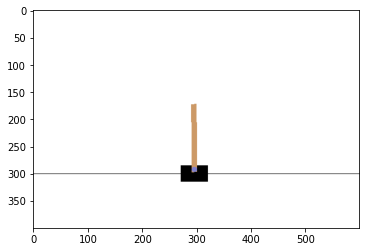

In [11]:
env = gym.make("CartPole-v0")
#env = gym.make("BipedalWalker-v3") # try for different environements
#env = gym.make('MountainCarContinuous-v0')
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

Print out the properties of the environment


In [12]:
print(venv.action_space)
print(venv.observation_space)

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


##Before training
Test in the environment the untrained policy.  
TODO: write the code to test the behaviour of the output policy on the environment. We will be able to select the action of the environment with

    a,_ = bc_trainer.policy.predict(s)

In [13]:
num_episodes = 10
rew_list=[]
from imitation.algorithms import adversarial, bc
bc_trainer = bc.BC(venv.observation_space, venv.action_space, expert_data=transitions)
for _ in range(num_episodes):
  #TODO: write the code to test the behaviour of the output policy on the environment for num_episodes 
    obs = env.reset()
    done, state = False, None
    episode_reward = 0.0
    episode_length = 0
    while not done:
        action, state = bc_trainer.policy.predict(obs, state=state, deterministic=True)
        obs, reward, done, _info = env.step(action)
        episode_reward += reward
        episode_length += 1
        env.render()
    rew_list.append(episode_reward)



In [14]:
print(rew_list)

[10.0, 8.0, 9.0, 9.0, 9.0, 8.0, 10.0, 9.0, 9.0, 9.0]


Plot the reward received by the bc_trainer

mean reward  9.0


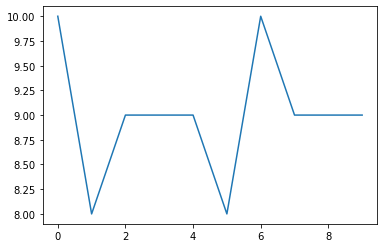

In [15]:
#check the learning process by plotting  the reward per episode 
plt.plot(rew_list)
print("mean reward ",np.mean(rew_list))

##After Training
Train the policy by behavioural cloning after training for 1 epoch

In [16]:
bc_trainer.train(n_epochs=1) 

BC epoch:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/collate.py:146: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return default_collate([torch.as_tensor(b) for b in batch])


-----------------------------
| batch_size    | 32        |
| ent_loss      | -0.000541 |
| entropy       | 0.541     |
| epoch_num     | 0         |
| l2_loss       | 0         |
| l2_norm       | 42.3      |
| loss          | 0.514     |
| n_updates     | 100       |
| neglogp       | 0.514     |
| prob_true_act | 0.648     |
-----------------------------
----------------------------
| batch_size    | 32       |
| ent_loss      | -0.00048 |
| entropy       | 0.48     |
| epoch_num     | 0        |
| l2_loss       | 0        |
| l2_norm       | 45       |
| loss          | 0.423    |
| n_updates     | 200      |
| neglogp       | 0.424    |
| prob_true_act | 0.711    |
----------------------------
-----------------------------
| batch_size    | 32        |
| ent_loss      | -0.000529 |
| entropy       | 0.529     |
| epoch_num     | 0         |
| l2_loss       | 0         |
| l2_norm       | 46.4      |
| loss          | 0.485     |
| n_updates     | 300       |
| neglogp       | 0.48

Test in the environment the output policy.

TODO: write the code to test the behaviour of the output policy on the environment and plot the rewards received. We will be able to select the action of the environment with 

      a,_ = bc_trainer.policy.predict(s)

In [17]:
num_episodes = 10
rew_list=[]

for _ in range(num_episodes):
  #TODO: write the code to test the behaviour of the output policy on the environment for num_episodes 
    obs = env.reset()
    done, state = False, None
    episode_reward = 0.0
    episode_length = 0
    while not done:
        action, state = bc_trainer.policy.predict(obs, state=state, deterministic=True)
        obs, reward, done, _info = env.step(action)
        episode_reward += reward
        episode_length += 1
        env.render()
    rew_list.append(episode_reward)

mean reward  200.0


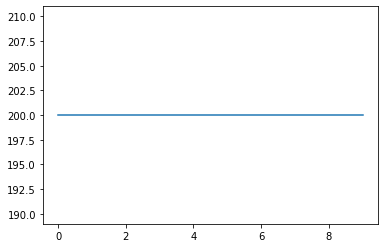

In [18]:
#check the learning process by plotting  the reward per episode 
plt.plot(rew_list)
print("mean reward ",np.mean(rew_list))

#Generative Adversarial Imitation Learning
Let us train with the algoirthm GAIL. See the  documentation and examples from : 


*  https://github.com/HumanCompatibleAI/imitation/tree/master/examples
*  https://stable-baselines3.readthedocs.io/en/master/guide/imitation.html
*  (deprecated) https://stable-baselines.readthedocs.io/en/v2.4.0/modules/gail.html 

GAIL relies on a RL algorithm in its inner loop. One option is the algorithm PPO, which is a policy gradient algorithm (see a short explanation in https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)

TODO: implement GAIL for the cartpole on the same expert data. Report the rewards with respect to the number of traning time steps. Comment the results and contrast with the results from Behaviour Cloning.

In [19]:
# Train GAIL on expert data.
# GAIL also accepts as `expert_data` any Pytorch-style DataLoader that
# iterates over dictionaries containing observations, actions, and next_observations.
logger.configure(tempdir_path / "GAIL/")

#TODO: implement GAIL for the cartpole on the loaded expert data
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
learner = PPO(
    env=venv,
    policy=MlpPolicy,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
)

gail_trainer = adversarial.GAIL(
    venv=venv, 
    expert_data=transitions,
    gen_algo=learner,
    expert_batch_size=1024


)

Logging to /tmp/quickstartvb28oqpw/GAIL


Test in the environment the output policy.

TODO: write the code to test the behaviour of the output policy on the environment. We will be able to select the action of the environment with 

      a,_ = gail_trainer.gen_algo.predict(s)

In [20]:
num_episodes = 10
rew_list=[]

for _ in range(num_episodes):
  #TODO: write the code to test the behaviour of the output policy on the environment for num_episodes 
    obs = env.reset()
    done, state = False, None
    episode_reward = 0.0
    episode_length = 0
    while not done:
        action, state = gail_trainer.gen_algo.predict(obs, state=state, deterministic=True)
        obs, reward, done, _info = env.step(action)
        episode_reward += reward
        episode_length += 1
        env.render()
    rew_list.append(episode_reward)
    
print('Complete')

Complete


mean reward  9.2


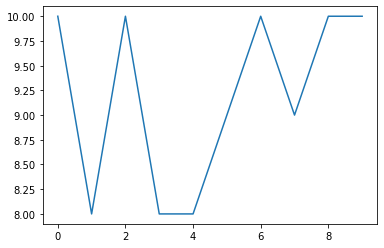

In [21]:
#check the learning process by plotting  the reward per episode 
plt.plot(rew_list)
print("mean reward ",np.mean(rew_list))

# A Robot environment with Pybullet

You can use a robot using pybullet physical simulator. Documentation about pybullet can be read on https://pybullet.org/wordpress/index.php/forum-2/.
Below is an example of code to use a robot arm or a humanoid agent.

In [6]:
#INSTALL THE PACKAGES
!pip3 install pybullet --upgrade
!pip3 install stable_baselines --upgrade
!pip3 install tensorflow==1.14.0 #tensorflow deprecates and breaks their API
#see PyBullet Quickstart Guide at
#https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit
!pip3 install pyvirtualdisplay > /dev/null 2>&1

     |████████████████████████████████| 91.7 MB 44 kB/s 
     |████████████████████████████████| 109.3 MB 39 kB/s 
     |████████████████████████████████| 3.1 MB 27.2 MB/s 
     |████████████████████████████████| 488 kB 51.8 MB/s 
     |████████████████████████████████| 50 kB 4.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

In [7]:
#connect to the physical simulator
import pybullet
import pybullet_data
datapath = pybullet_data.getDataPath()
pybullet.connect(pybullet.DIRECT)

0

PyBullet offers several robotics environments. 

The implementation of the Kuka robot arm can be found in https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/bullet/kukaGymEnv.py.

The implementation of the humanoid, ant ... can be found in https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/gym_locomotion_envs.py. 

The implementation fo the reacher can be found in https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/gym_manipulator_envs.py

Documentation on the mujoco humanoid environment is : https://github.com/openai/gym/wiki/Humanoid-V1

You can also find a documentation on PyBullet on https://usermanual.wiki/Document/PyBullet20Quickstart20Guide.543993445/html or https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#heading=h.2ye70wns7io3, including the API functions to control the robot from page 18. 


Below is an example code to run the Humanoid environment

In [8]:
import gym
import time
import pybullet_envs

#Below are a few examples of agents in pybullet
env = gym.make("HumanoidBulletEnv-v0")
# env = gym.make("AntBulletEnv-v0")
# env = gym.make("HalfCheetahBulletEnv-v0")
# env = gym.make('ReacherBulletEnv-v0')

# env = gym.make("KukaBulletEnv-v0") #KUKA robot arm grasping environments
#https://programmersought.com/article/69341201576/
#The environment uses the KUKA liwa robotic arm with the goal of grabbing objects placed in the tray. When the robot arm grabs the target to a certain height, the system is rewarded. In order to optimize the entire crawling process, a small amount of reward is given based on the distance between the action, the gripper and the target. The observed value (ie, state) is represented by the coordinate value (x, y) of the target.
#The observations in KukaCamBulletEnv-v0 are represented by camera pixel values, and the others are identical to the previous version (ie camera pixels).
#https://colab.research.google.com/github/mahyaret/kuka_rl/blob/master/kuka_rl_2.ipynb
#https://github.com/mahyaret/kuka_rl


# env = gym.make("CartPoleBulletEnv-v0")


# Display information about the environment
aspace = env.action_space
ospace = env.observation_space
print("The action space is {}".format(aspace))
print("The dimension of the action space is {}".format(aspace.shape[0]))
print("The observation space is {}".format(ospace))
#env.render(mode="human")
obs= env.reset()
print("obs ",obs)
obs= env.reset()
print("obs ",obs)
obs= env.reset()
print("obs ",obs)
images = []




The action space is Box(-1.0, 1.0, (17,), float32)
The dimension of the action space is 17
The observation space is Box(-inf, inf, (44,), float32)
obs  [ 5.9999996e-01  2.5130539e-05  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00
 -1.0216924e-01  0.0000000e+00  3.7518045e-01  0.0000000e+00
 -1.4659443e-01  0.0000000e+00  6.4552003e-01  0.0000000e+00
  3.1533560e-01  0.0000000e+00  7.1036887e-01  0.0000000e+00
  1.0215372e+00  0.0000000e+00  1.0156112e+00  0.0000000e+00
  2.7395913e-01  0.0000000e+00  7.6319152e-01  0.0000000e+00
  1.0939294e+00  0.0000000e+00  1.4395086e-01  0.0000000e+00
  2.3492184e-01  0.0000000e+00  3.3821422e-01  0.0000000e+00
 -2.0603563e-01  0.0000000e+00 -1.5044782e-01  0.0000000e+00
  2.4746338e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00]
obs  [ 5.9999996e-01 -7.7249533e-06  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00
  1.0703803e-01  0.0000000e+00  3.4600884e-01  0.

To display a simulated episode.

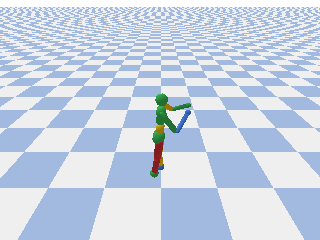

In [7]:
#run an episode of 20 steps
#while True:
for i in range(20):
    #env.render(mode="human")
    time.sleep(0.01)
    action = env.action_space.sample()
    # print("action: {}".format(action))
    observation, _, done, info = env.step(action)
    img = env.render(mode='rgb_array')
    images.append(img)
    
    
#display the video
from IPython.display import Image
!pip3 install numpngw
from numpngw import write_apng

#imageio.mimsave('a2c.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
write_apng('anim.png', images, delay=20)
Image(filename='anim.png')

TODO : Train your agent with an algorithm of your choice. You can implement yourself the algorithm or use stable_baselines library. Report the performance of your agent by plotting the reward with respect to the training steps.

#Use SAC to train for 270,000 timesteps

In [11]:
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from matplotlib import pyplot as plt

model = SAC('MlpPolicy',env,verbose=1)
rwds = []
for i in range(270000): 
  model.learn(1,reset_num_timesteps=False,log_interval=1000)
  if i%1000==0:
    mean_rwd,_ = evaluate_policy(model,env,n_eval_episodes=10)
    rwds.append(mean_rwd)
    print(i,mean_rwd)

plt.plot(rwds)

Using cuda device
Wrapping the env in a DummyVecEnv.
0 36.39421197076968
1000 26.83510776155119
2000 44.16945840263404
3000 42.35614624964889
4000 25.51312059652424
5000 25.10000782095769
6000 18.586925182631525
7000 16.216012664985318
8000 10.132091332010457
9000 -12.277805100387924
10000 -12.61149642167191
11000 -5.8874177521560345
12000 33.75597256967826
13000 2.26927297771588
14000 13.690945666867776
15000 15.131562223039655
16000 4.646710340467105
17000 1.414207204462872
18000 15.537728811914567
19000 27.328100335873604
20000 8.126865071338397
21000 3.0440833926068427
22000 14.366984532846837
23000 4.654967995951151
24000 0.7233362603206459
25000 24.363845607876573
26000 -8.079343955787921
27000 18.905488229581092
28000 18.244551683680182
29000 16.401793547775746
30000 26.777243440391317
31000 -3.6157635026246155
32000 16.360825688480254
33000 13.665918872714974
34000 27.650604710856566
35000 24.15663102962193
36000 36.70673164891792
37000 22.740983885801107
38000 29.9421586087647

KeyboardInterrupt: ignored

#Plot the rewards during 270,000 timesteps

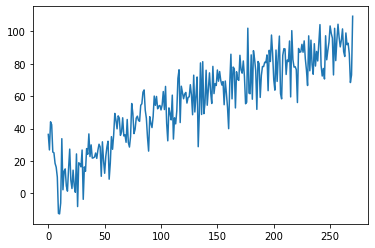

In [12]:
plt.plot(rwds)

# Training result visualization

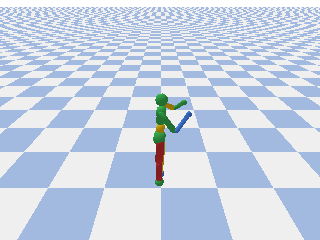

In [24]:
#run an episode of 20 steps
#while True:
images=[]
obs = env.reset()
for i in range(50):
    #env.render(mode="human")
    time.sleep(0.01)
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)    
    img = env.render(mode='rgb_array')
    images.append(img)
    
    
#display the video
from IPython.display import Image
!pip3 install numpngw
from numpngw import write_apng

#imageio.mimsave('a2c.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
write_apng('anim.png', images, delay=20)
Image(filename='anim.png')

# Use the trained agent as a new expert

TODO : use the previously trained agent to constitute an expert dataset

In [27]:
#TODO : obtain a demonstration dataset from the previously trained agent

#Create a dataset of size 100,000

In [ ]:
import numpy as np
model.save('SAC')

actions = []
obs = []
next_obs = []
dones = []
infos = []
for i in range(100000):
    if i % 1000 == 0:
      print(i)
    ob = env.reset()
    action, state = model.predict(ob)
    next_ob,_,done,info = env.step(action)
    actions.append(action)
    obs.append(ob)
    next_obs.append(next_ob)
    infos.append(info)
    dones.append(done)
np.savez('expert_data',actions = actions, obs = obs, next_obs = next_obs, dones = dones,infos = infos)


#Load dataset

In [10]:
with np.load('expert_data.npz',allow_pickle=True) as data:
  actions = data['actions']
  obs = data['obs']
  next_obs = data['next_obs']
  dones = data['dones']
  infos = data['infos']

In [11]:
from imitation.data.types import Transitions,save,load
trajet = Transitions(obs,actions,infos,next_obs,dones)
save("expert_data_tr",trajet)

# IMITATION LEARNING from the new expert

TODO: implement an imitation learning of your choice for the same agent and environment. You can implement yourself the algorithm or use stable_baselines library. Using the new demonstration dataset, report the performance of your agent. Compare this performance to the performance of the new expert.

In [29]:
#TODO: implement an imitation learning of your choice for the same agent and environment. 
#TODO: Using the new demonstration dataset, report the performance of your agent.
from imitation.algorithms import  bc
bc_trainer = bc.BC(env.observation_space, env.action_space, expert_data=trajet)
bc_trainer.train(n_epochs=50,log_interval = 100000) 

BC epoch:   0%|          | 0/50 [00:00<?, ?it/s]

----------------------------
| batch_size    | 32       |
| ent_loss      | 0.0231   |
| entropy       | -23.1    |
| epoch_num     | 31       |
| l2_loss       | 0        |
| l2_norm       | 205      |
| loss          | -23.5    |
| n_updates     | 100000   |
| neglogp       | -23.5    |
| prob_true_act | 3.69e+11 |
----------------------------


In [28]:
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(bc_trainer.policy, env, n_eval_episodes=10)
print(mean_reward)

68.19235647843014


##analyse:

<br>
Since we have returned to China, we can only connect to google colab via vpn due to the firewall, the connection is unstable and the training is slow. Therefore, the training cannot be successfully continued for a long time.
<br>
We chose Soft Actor-Critic (SAC) Baseline and only trained 270,000 epochs (then it breaks). We made a curve of rewards changing with timesteps and found that rewards continued to rise, but still did not converge. The final rewards were only about 100, but we believe it will still keep going up if we have enough colab resources to continue training.
<br>
Using the trained model, we made a dataset and named it expert_data.npz, which contains 100,000 groups of observations, actions, next_observation, etc. We use the bc method in imitation learning, and the average reward obtained after training for 50 epochs is around 68.

